# Training a FFNN in dCGPANN vs. Keras (classification)

A Feed Forward Neural network is a widely used ANN model for regression and classification. Here we show how to encode it into a dCGPANN and train it with stochastic gradient descent on a regression task. To check the correctness of the result we perform the same training using the widely used Keras Deep Learning toolbox.

In [1]:
# Initial import
import dcgpy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import timeit

%matplotlib inline

### Data set

In [2]:
# We import the data for a classification task. 8 inputs 29 classes
from numpy import genfromtxt
# https://archive.ics.uci.edu/ml/datasets/Abalone
my_data = genfromtxt('abalone_data_set.csv', delimiter=',')
points = my_data[:,:-1]
labels_tmp = my_data[:,-1]
# We trasform the categorical variables to one hot encoding
labels = np.zeros((len(labels_tmp), 29))
for i,l in enumerate(labels_tmp):
    labels[i][int(l)-1] = 1
# We shuffle the dataset
points, labels = shuffle(points, labels, random_state=0)
# And split the data into training and test
X_train = points[:3000]
Y_train = labels[:3000]
X_test = points[3000:]
Y_test = labels[3000:]


### Encoding and training a FFNN using dCGP

There are many ways the same FFNN could be encoded into a CGP chromosome. The utility *encode_ffnn* selects one for you returning the expression.

In [18]:
# We encode a FFNN into a dCGP expression. Note that the last layer is made by a sum activation function
# so that categorical cross entropy can be used and produce a softmax activation last layer. 
# In a dCGP the concept of layers is absent and neurons are defined by activation functions R->R.
dcgpann = dcgpy.encode_ffnn(8,29,[50,20],["sig", "sig", "sum"], 5)

# By default all weights (and biases) are set to 1 (and 0). We initialize the weights normally distributed
dcgpann.randomise_weights(mean = 0., std = 1.)
dcgpann.randomise_biases(mean = 0., std = 1.)


print("Starting error:", dcgpann.loss(X_test,Y_test, "CE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))

#dcgpann.visualize(show_nonlinearities=True, legend=True)

Starting error: 5.5763577557288935
Net complexity (number of active weights): 1980
Net complexity (number of unique active weights): 1980
Net complexity (number of active nodes): 107


In [19]:
res = []

# We train
n_epochs = 100
print("Start error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("Start error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)

start_time = timeit.default_timer()
for i in tqdm(range(n_epochs)):
    res.append(dcgpann.sgd(X_train, Y_train, 1., 32, "CE"))
elapsed = timeit.default_timer() - start_time

print("End error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("End error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)
print("Time:", elapsed, flush=True)





Start error (training set): 5.575363794991069
Start error (test): 5.577471487328636


100%|██████████| 100/100 [00:03<00:00, 33.22it/s]

End error (training set): 2.4992372594172507
End error (test): 2.5419189289660338
Time: 3.013858211999832


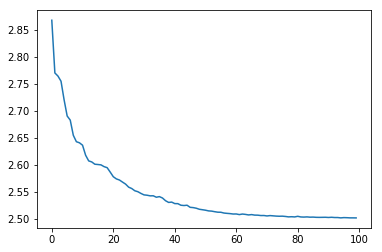

In [17]:
plt.plot(res)

### Same training is done using Keras (Tensor Flow backend)


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# We define Stochastic Gradient Descent as an optimizer
sgd = optimizers.SGD(lr=1.)
# We define weight initializetion
initializerw = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)
initializerb = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)

model = Sequential([
    Dense(50, input_dim=8, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(29, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('softmax'),
])
model.compile(optimizer=sgd,
              loss='categorical_crossentropy')


Using TensorFlow backend.


In [17]:
start_time = timeit.default_timer()
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=False)
elapsed = timeit.default_timer() - start_time
print("End error (training set):", model.evaluate(X_train,Y_train, verbose=False))
print("End error (test):", model.evaluate(X_test,Y_test, verbose=False))
print("Time:", elapsed)

End error (training set): 1.9241167055765789
End error (test): 2.0035097807671116
Time: 6.769632533001641


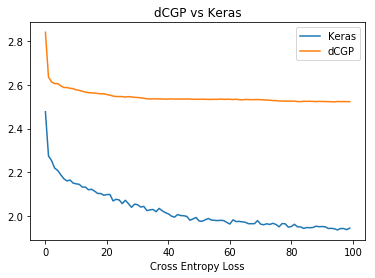

In [18]:
# We plot for comparison the MSE during learning in the two cases
plt.plot(history.history['loss'], label='Keras')
plt.plot(res, label='dCGP')
plt.title('dCGP vs Keras')
plt.xlabel('epochs')
plt.legend()
_ = plt.xlabel('Cross Entropy Loss')